# **Analysis of Green House Gases Emitted by America's 3rd Largest City**

In an effort to stave off the environmental crisis that is predicted to occur later this century, many cities have begun to implement policies with the objective of reducing the ecological impact that urban places have on the environment due to their advanced industrialization. Thus, our goal is to analyze the energy program of one such city, Chicago, Illinois, to measure the success of their efforts as a whole, and locate any other trends regarding energy use in the city. 



**Imports**

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices
from sklearn import metrics, model_selection, tree, ensemble, neighbors
#import geopandas as gpd
from shapely.geometry import Point, Polygon
import scipy.stats as stats
import matplotlib.pyplot as plt
import math
import statsmodels.formula.api as smf

In [53]:
url = "https://data.cityofchicago.org/resource/xq83-jr8c.csv?$limit=17728"
df = pd.read_csv(url)

### **Data Cleaning** 

In [54]:
north = [
    'Rogers Park',
    'Edgewater',
    'Lincoln Square',
    'Uptown',
    'North Center',
    'Roscoe Village',
    'Lakeview',
    'Lincoln Park',
    'Old Town',
    'Gold Coast',
    'River North',
    'Streeterville',
    'Near North Side',
    'Albany Park',
    'Lake View',
    'Dunning',
    'West Ridge',
    'Norwood Park',
    "O'Hare",
    'Montclare',
    'North Park',
    'Edison Park',
]

west = [
    'Forest Glen',
    'Jefferson Park',
    'Portage Park',
    'Irving Park',
    'Avondale',
    'Logan Square',
    'Bucktown',
    'Wicker Park',
    'Humboldt Park',
    'West Town',
    'West Loop',
    'Little Italy',
    'University Village',
    'Pilsen',
    'Belmont Cragin',
    'Hermosa'

]

south = [
    'Bridgeport',
    'Armour Square',
    'Bronzeville',
    'South Loop',
    'Hyde Park',
    'Kenwood',
    'South Shore',
    'Beverly',
    'Mckinley Park',
    'Near South Side'
]

In [55]:
df = df.dropna(subset = ['community_area'])
df.reset_index(drop = True, inplace = True)
communities_featured = df['community_area'].unique()

communities_featured

array(['HYDE PARK', 'KENWOOD', 'NEAR WEST SIDE', 'NEAR NORTH SIDE',
       'Englewood', 'LINCOLN PARK', 'NEAR SOUTH SIDE', 'Loop',
       'ROGERS PARK', 'GAGE PARK', 'North Center', 'DUNNING', 'WEST TOWN',
       'UPTOWN', 'BELMONT CRAGIN', 'LAKE VIEW', 'LOOP', 'DOUGLAS',
       'Near South Side', 'Near North Side', 'Lake View', 'CHICAGO LAWN',
       'PORTAGE PARK', 'WASHINGTON HEIGHTS', 'HERMOSA', 'LINCOLN SQUARE',
       'ENGLEWOOD', 'EDGEWATER', 'EAST GARFIELD PARK', 'SOUTH LAWNDALE',
       'Lincoln Park', 'Rogers Park', 'AVONDALE', 'ASHBURN',
       'SOUTH SHORE', 'HEGEWISCH', 'WEST RIDGE', 'Auburn Gresham',
       'AUSTIN', 'EAST SIDE', 'NORTH LAWNDALE', 'LOWER WEST SIDE',
       'MORGAN PARK', 'ARCHER HEIGHTS', 'WEST LAWN', 'LOGAN SQUARE',
       'CHATHAM', 'GREATER GRAND CROSSING', 'GRAND BOULEVARD',
       'WEST ELSDON', 'Logan Square', 'Near West Side', 'OAKLAND',
       'MCKINLEY PARK', 'BRIDGEPORT', 'Garfield Ridge', 'SOUTH CHICAGO',
       'ALBANY PARK', 'NORWOOD PARK', '

In [56]:
iterator = len(df['community_area'])
for i in range(iterator):
  df['community_area'][i] = df['community_area'][i].title()

<ipython-input-56-03894fe52fc3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['community_area'][i] = df['community_area'][i].title()


In [57]:
hoods = df['community_area'].unique()
neighborhoods = [*north, *west, *south]
missing_hoods = []
for n in hoods:
  if n not in neighborhoods:
    missing_hoods.append(n)

In [58]:
def checkHoods(l1, l2, l3):
  hoods = df['community_area'].unique()
  
  neighborhoods = [*l1, *l2, *l3]

  missing_hoods = []
  
  for n in hoods:
    if n not in neighborhoods:
      missing_hoods.append(n)

  return missing_hoods


In [59]:
l = len(df['community_area'])

for i in range(l):
  if df['community_area'][i] == 'Ohare':
    df['community_area'][i] = "O'Hare"
    
checkHoods(north,west,south)

<ipython-input-59-7cf2c64ade5c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['community_area'][i] = "O'Hare"


['Near West Side',
 'Englewood',
 'Loop',
 'Gage Park',
 'Douglas',
 'Chicago Lawn',
 'Washington Heights',
 'East Garfield Park',
 'South Lawndale',
 'Ashburn',
 'Hegewisch',
 'Auburn Gresham',
 'Austin',
 'East Side',
 'North Lawndale',
 'Lower West Side',
 'Morgan Park',
 'Archer Heights',
 'West Lawn',
 'Chatham',
 'Greater Grand Crossing',
 'Grand Boulevard',
 'West Elsdon',
 'Oakland',
 'Garfield Ridge',
 'South Chicago',
 'West Englewood',
 'Woodlawn',
 'Burnside',
 'Fuller Park',
 'Brighton Park',
 'New City',
 'Avalon Park',
 'Outside Chicago, In Bedford Park',
 'Washington Park',
 'Roseland',
 'Pullman',
 'West Pullman',
 'South Deering',
 'West Garfield Park',
 'Riverdale',
 'Clearing',
 'Calumet Heights',
 'Mount Greenwood']

In [60]:
df['region'] = [0] * len(df)

for i in range(len(df)):
  if df['community_area'][i] in north:
    df['region'][i] = 'North'
  elif df['community_area'][i] in south:
    df['region'][i] = 'South'
  elif df['community_area'][i] in west:
    df['region'][i] = 'West'
  else:
    if df['community_area'][i] == 'Loop':
      df['region'][i] = 'Loop'
    else:
      df['region'][i] = 'Outside Chicago, In Bedford Park'

<ipython-input-60-e157d7ce3a4d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['region'][i] = 'South'


In [61]:
df.head()

,data_year,id,property_name,reporting_status,address,zip_code,chicago_energy_rating,exempt_from_chicago_energy_rating,community_area,primary_property_type,...,source_eui_kbtu_sq_ft,weather_normalized_site_eui_kbtu_sq_ft,weather_normalized_source_eui_kbtu_sq_ft,total_ghg_emissions_metric_tons_co2e,ghg_intensity_kg_co2e_sq_ft,latitude,longitude,location,row_id,region
0,2020,252064,Mansueto Library,Submitted Data,1100 E 57th St,60637,2.0,False,Hyde Park,Library,...,323.6,246.0,329.9,1160.9,18.1,41.792213,-87.599950,"(41.79221307, -87.59994981)",2020-252064,South
1,2020,232458,Harper Square Cooperative,Submitted Data,4800 - 4850 S Lake Park Ave,60615,1.0,False,Kenwood,Multifamily Housing,...,146.0,100.3,150.7,4871.7,7.8,41.807475,-87.591264,"(41.80747487, -87.59126397)",2020-232458,South
2,2020,254616,Former Coyne College,Submitted Data,330 N Green St,60607,2.0,False,Near West Side,Office,...,148.3,56.7,151.8,4581.4,8.2,41.873335,-87.651021,"(41.873335, -87.65102071)",2020-254616,"Outside Chicago, In Bedford Park"
3,2020,103812,400 W Superior St,Submitted Data,400 W Superior St,60654,3.0,False,Near North Side,Office,...,151.8,63.0,154.8,1092.1,8.4,41.895752,-87.638901,"(41.89575232, -87.638901)",2020-103812,North
4,2020,254073,Blue Moon Lofts,Submitted Data,215 N. Aberdeen St.,60607,4.0,False,Near West Side,Multifamily Housing,...,64.9,29.6,64.3,295.8,3.6,41.874295,-87.650175,"(41.87429514, -87.65017516)",2020-254073,"Outside Chicago, In Bedford Park"


## **Descriptive Analytics**

In [62]:
df.describe()

,data_year,id,chicago_energy_rating,gross_floor_area_buildings_sq_ft,year_built,of_buildings,water_use_kgal,energy_star_score,electricity_use_kbtu,natural_gas_use_kbtu,...,district_chilled_water_use_kbtu,all_other_fuel_use_kbtu,site_eui_kbtu_sq_ft,source_eui_kbtu_sq_ft,weather_normalized_site_eui_kbtu_sq_ft,weather_normalized_source_eui_kbtu_sq_ft,total_ghg_emissions_metric_tons_co2e,ghg_intensity_kg_co2e_sq_ft,latitude,longitude
count,17637.000000,17637.000000,9668.000000,1.628400e+04,15057.000000,15651.000000,3.403000e+03,12850.000000,1.511900e+04,1.379700e+04,...,5.570000e+02,8.200000e+01,15102.000000,14243.000000,14029.000000,12669.000000,13986.000000,13981.000000,17637.000000,17637.000000
mean,2017.810795,185892.172875,2.224969,2.614545e+05,1963.479843,1.386876,2.165936e+04,58.212529,1.167979e+07,1.350438e+07,...,1.817472e+07,1.284665e+06,101.453357,181.768097,102.681531,181.214745,2828.868182,10.249956,41.882060,-87.653766
std,1.650440,60338.097225,1.523180,4.237493e+05,36.959752,4.909822,6.828724e+05,27.663227,2.876602e+07,3.772826e+07,...,3.140002e+07,3.415031e+06,260.322282,299.101300,226.977062,231.763600,6573.547324,15.689237,0.069403,0.047546
min,2014.000000,100001.000000,0.000000,8.000000e+03,1692.000000,1.000000,4.000000e-01,1.000000,2.140000e+02,2.320000e+01,...,-1.383204e+06,3.450000e+03,0.100000,0.200000,0.100000,0.200000,0.700000,0.000000,41.651404,-87.905562
25%,2016.000000,121374.000000,1.000000,7.530000e+04,1928.000000,1.000000,1.292500e+03,37.000000,1.911346e+06,3.456300e+06,...,4.205688e+06,3.148525e+04,62.000000,110.500000,64.200000,114.500000,593.575000,6.100000,41.852586,-87.668298
50%,2018.000000,173862.000000,2.500000,1.271000e+05,1969.000000,1.000000,3.153000e+03,62.000000,4.254720e+06,6.169360e+06,...,8.797560e+06,6.899310e+04,80.600000,142.900000,83.500000,146.800000,1139.000000,7.900000,41.887692,-87.641278
75%,2019.000000,251463.000000,4.000000,2.770815e+05,1998.000000,1.000000,6.977500e+03,82.000000,1.030159e+07,1.321387e+07,...,2.121487e+07,1.325835e+05,103.400000,192.700000,106.800000,195.000000,2579.750000,11.000000,41.922422,-87.626669
max,2020.000000,260184.000000,4.000000,9.245333e+06,2020.000000,236.000000,3.787893e+07,100.000000,9.923283e+08,1.642941e+09,...,3.762233e+08,2.098180e+07,15634.500000,16485.400000,14392.800000,11802.400000,185162.100000,834.900000,42.021720,-87.527913


In [63]:
df.dtypes

data_year                                     int64
id                                            int64
property_name                                object
reporting_status                             object
address                                      object
zip_code                                     object
chicago_energy_rating                       float64
exempt_from_chicago_energy_rating            object
community_area                               object
primary_property_type                        object
gross_floor_area_buildings_sq_ft            float64
year_built                                  float64
of_buildings                                float64
water_use_kgal                              float64
energy_star_score                           float64
electricity_use_kbtu                        float64
natural_gas_use_kbtu                        float64
district_steam_use_kbtu                     float64
district_chilled_water_use_kbtu             float64
all_other_fu

In [64]:
df['primary_property_type'].value_counts()

Multifamily Housing                                 7051
Office                                              2137
K-12 School                                         2112
College/University                                   533
Hotel                                                440
Retail Store                                         305
Senior Care Community                                277
Supermarket/Grocery Store                            271
Mixed Use Property                                   205
Hospital (General Medical & Surgical)                177
Residence Hall/Dormitory                             149
Laboratory                                           149
Strip Mall                                           138
Other                                                128
Other - Recreation                                    88
Medical Office                                        84
Worship Facility                                      72
Senior Living Community        

In [65]:
df_property = df.groupby("primary_property_type").agg("mean").reset_index()

<ipython-input-65-6bdf0ae4ab3e>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_property = df.groupby("primary_property_type").agg("mean").reset_index()


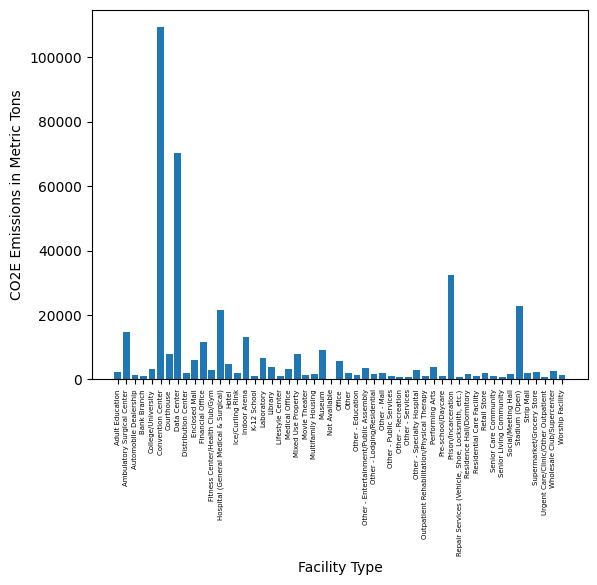

In [66]:
plt.bar(df_property['primary_property_type'], df_property['total_ghg_emissions_metric_tons_co2e'])
plt.xticks(rotation = 90, fontsize = 5) 
plt.xlabel("Facility Type", fontsize = 10)
plt.ylabel("CO2E Emissions in Metric Tons")
plt.show()

In [67]:
df.columns

Index(['data_year', 'id', 'property_name', 'reporting_status', 'address',
       'zip_code', 'chicago_energy_rating',
       'exempt_from_chicago_energy_rating', 'community_area',
       'primary_property_type', 'gross_floor_area_buildings_sq_ft',
       'year_built', 'of_buildings', 'water_use_kgal', 'energy_star_score',
       'electricity_use_kbtu', 'natural_gas_use_kbtu',
       'district_steam_use_kbtu', 'district_chilled_water_use_kbtu',
       'all_other_fuel_use_kbtu', 'site_eui_kbtu_sq_ft',
       'source_eui_kbtu_sq_ft', 'weather_normalized_site_eui_kbtu_sq_ft',
       'weather_normalized_source_eui_kbtu_sq_ft',
       'total_ghg_emissions_metric_tons_co2e', 'ghg_intensity_kg_co2e_sq_ft',
       'latitude', 'longitude', 'location', 'row_id', 'region'],
      dtype='object')

In [68]:
df['data_year'].unique()

array([2020, 2018, 2015, 2019, 2016, 2017, 2014])

In [69]:
df_year = df.groupby('data_year').agg('mean').reset_index()
df_year

<ipython-input-69-7de2b0b913a9>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_year = df.groupby('data_year').agg('mean').reset_index()


,data_year,id,chicago_energy_rating,gross_floor_area_buildings_sq_ft,year_built,of_buildings,water_use_kgal,energy_star_score,electricity_use_kbtu,natural_gas_use_kbtu,...,district_chilled_water_use_kbtu,all_other_fuel_use_kbtu,site_eui_kbtu_sq_ft,source_eui_kbtu_sq_ft,weather_normalized_site_eui_kbtu_sq_ft,weather_normalized_source_eui_kbtu_sq_ft,total_ghg_emissions_metric_tons_co2e,ghg_intensity_kg_co2e_sq_ft,latitude,longitude
0,2014,120148.917695,NaN,883105.864198,1963.304527,1.769547,NaN,68.140000,5.542168e+07,4.589587e+07,...,2.526512e+07,1.625105e+06,108.979424,244.201646,105.704348,239.336087,13193.679167,15.036417,41.877718,-87.646044
1,2015,192239.406312,NaN,341206.135437,1961.325444,1.617357,NaN,56.975000,1.633294e+07,1.875206e+07,...,1.702036e+07,1.074887e+06,120.251348,224.441091,123.467686,228.218285,4232.894772,13.367042,41.875761,-87.655775
2,2016,184277.504233,NaN,244414.647700,1962.731932,1.408907,NaN,60.012609,1.081069e+07,1.191014e+07,...,1.759946e+07,1.100594e+06,94.208408,180.017820,99.133296,184.965500,2630.786495,10.103629,41.885083,-87.653376
3,2017,184593.453700,NaN,241715.158742,1963.099392,1.385413,NaN,58.970280,1.027161e+07,1.165939e+07,...,1.467572e+07,1.251777e+06,92.282470,174.298370,96.633284,179.308211,2525.770200,9.786224,41.884620,-87.653710
4,2018,186231.882216,2.324163,223978.243965,1963.596161,1.339067,5821.032383,54.835639,1.033754e+07,1.369156e+07,...,1.657300e+07,1.453639e+06,109.164391,180.613151,100.902824,171.365567,2454.252365,10.087143,41.881521,-87.653690
5,2019,187458.278507,1.788754,272716.787049,1966.996154,1.272727,176925.224127,57.318542,1.186872e+07,1.447516e+07,...,2.270963e+07,NaN,111.145698,201.260910,116.437059,NaN,3010.464387,11.751799,41.881079,-87.653536
6,2020,188122.362000,2.552978,242676.682767,1963.054652,1.352348,NaN,59.539670,8.833887e+06,1.108588e+07,...,1.885634e+07,NaN,91.385225,154.345058,95.639767,159.339697,1976.644542,8.305792,41.882194,-87.654075


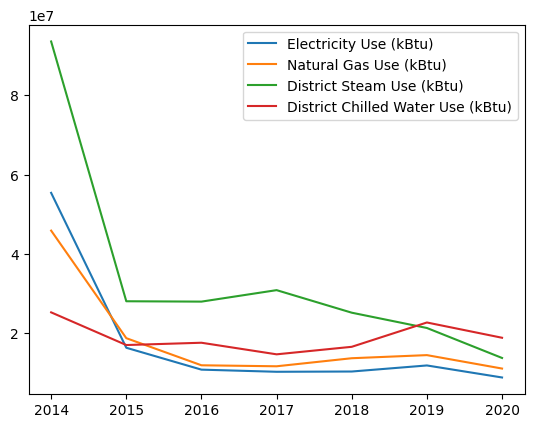

In [70]:
plt.plot(df_year["data_year"], df_year["electricity_use_kbtu"])
plt.plot(df_year["data_year"], df_year["natural_gas_use_kbtu"])
plt.plot(df_year["data_year"], df_year['district_steam_use_kbtu'])
plt.plot(df_year["data_year"], df_year['district_chilled_water_use_kbtu'])
plt.legend(['Electricity Use (kBtu)', 'Natural Gas Use (kBtu)', 'District Steam Use (kBtu)', 'District Chilled Water Use (kBtu)'])
plt.show()

In [71]:
df_old = df[df["data_year"] < 2020]
df_old_rating = df_old[df_old["exempt_from_chicago_energy_rating"] == False]
df_old_rating

,data_year,id,property_name,reporting_status,address,zip_code,chicago_energy_rating,exempt_from_chicago_energy_rating,community_area,primary_property_type,...,source_eui_kbtu_sq_ft,weather_normalized_site_eui_kbtu_sq_ft,weather_normalized_source_eui_kbtu_sq_ft,total_ghg_emissions_metric_tons_co2e,ghg_intensity_kg_co2e_sq_ft,latitude,longitude,location,row_id,region
3503,2018,175676,4554 N BROADWAY ST,Not Submitted,4554 N BROADWAY ST,60640,0.0,False,Uptown,NaN,...,NaN,NaN,NaN,NaN,NaN,41.964650,-87.657324,"(41.96465048, -87.65732443)",2018-175676,North
3505,2018,103617,33 E Congress,Not Submitted,33 E Congress Pkwy,60605,0.0,False,Loop,NaN,...,NaN,NaN,NaN,NaN,NaN,41.875401,-87.626511,"(41.87540112, -87.62651136)",2018-103617,Loop
3507,2018,101263,900 W ARGYLE ST,Not Submitted,900 W ARGYLE ST,60640,0.0,False,Uptown,NaN,...,NaN,NaN,NaN,NaN,NaN,41.972230,-87.664596,"(41.97223008, -87.6645957)",2018-101263,North
3512,2018,252078,UNO Soccer Academy High School,Not Submitted,5025 S ST LOUIS,60632,0.0,False,Gage Park,NaN,...,NaN,NaN,NaN,NaN,NaN,41.808065,-87.710977,"(41.80806486, -87.71097656)",2018-252078,"Outside Chicago, In Bedford Park"
3520,2018,101420,Chicago Acad-CPS,Submitted,3400 N Austin Ave,60634,2.0,False,Dunning,K-12 School,...,149.2,95.1,146.6,2062.6,8.2,41.942538,-87.777370,"(41.94253753, -87.77737003)",2018-101420,North
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17632,2019,260132,Q11970,Submitted,2401 W Grace St,60618,3.0,False,North Center,NaN,...,165.6,71.7,NaN,NaN,NaN,41.950035,-87.688779,"(41.95003548, -87.68877942)",2019-260132,North
17633,2019,260135,309-315 W. 23rd St. Condominium Assocation,Submitted,309 W 23RD ST,60616,4.0,False,Armour Square,Multifamily Housing,...,NaN,NaN,NaN,NaN,NaN,41.845504,-87.630557,"(41.84550365, -87.63055693)",2019-260135,South
17634,2019,260149,Riverside Square and River's Edge - Chicago,Submitted,3145 S Ashland Ave,60608,2.0,False,Mckinley Park,Supermarket/Grocery Store,...,566.2,253.4,NaN,2448.1,32.9,41.836579,-87.663845,"(41.8365795, -87.66384491)",2019-260149,South
17635,2019,260150,Cummings Life Science Center,Submitted,920 E 58th St,60637,2.0,False,Hyde Park,Laboratory,...,783.4,413.8,NaN,7815.5,45.3,41.789880,-87.602764,"(41.78987998, -87.60276375)",2019-260150,South


In [72]:
df_new = df[df["data_year"] >= 2020]
df_new_rating = df_new[df_new["exempt_from_chicago_energy_rating"] == False]
df_new_rating

,data_year,id,property_name,reporting_status,address,zip_code,chicago_energy_rating,exempt_from_chicago_energy_rating,community_area,primary_property_type,...,source_eui_kbtu_sq_ft,weather_normalized_site_eui_kbtu_sq_ft,weather_normalized_source_eui_kbtu_sq_ft,total_ghg_emissions_metric_tons_co2e,ghg_intensity_kg_co2e_sq_ft,latitude,longitude,location,row_id,region
0,2020,252064,Mansueto Library,Submitted Data,1100 E 57th St,60637,2.0,False,Hyde Park,Library,...,323.6,246.0,329.9,1160.9,18.1,41.792213,-87.599950,"(41.79221307, -87.59994981)",2020-252064,South
1,2020,232458,Harper Square Cooperative,Submitted Data,4800 - 4850 S Lake Park Ave,60615,1.0,False,Kenwood,Multifamily Housing,...,146.0,100.3,150.7,4871.7,7.8,41.807475,-87.591264,"(41.80747487, -87.59126397)",2020-232458,South
2,2020,254616,Former Coyne College,Submitted Data,330 N Green St,60607,2.0,False,Near West Side,Office,...,148.3,56.7,151.8,4581.4,8.2,41.873335,-87.651021,"(41.873335, -87.65102071)",2020-254616,"Outside Chicago, In Bedford Park"
3,2020,103812,400 W Superior St,Submitted Data,400 W Superior St,60654,3.0,False,Near North Side,Office,...,151.8,63.0,154.8,1092.1,8.4,41.895752,-87.638901,"(41.89575232, -87.638901)",2020-103812,North
4,2020,254073,Blue Moon Lofts,Submitted Data,215 N. Aberdeen St.,60607,4.0,False,Near West Side,Multifamily Housing,...,64.9,29.6,64.3,295.8,3.6,41.874295,-87.650175,"(41.87429514, -87.65017516)",2020-254073,"Outside Chicago, In Bedford Park"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3496,2020,254174,NaN,Submitted Data,4200 W Diversey Ave,60639,3.0,False,Hermosa,Other,...,106.7,68.7,112.9,807.5,5.7,41.920398,-87.756200,"(41.9203976, -87.7562)",2020-254174,West
3497,2020,251529,Lovett Elementary -CPS,Submitted Data,6333 W Bloomingdale Ave,60639,4.0,False,Austin,K-12 School,...,101.5,78.9,106.9,454.5,5.3,41.912786,-87.783130,"(41.912786, -87.78313)",2020-251529,"Outside Chicago, In Bedford Park"
3498,2020,250114,Zelda Ormes Senior Apartments,Submitted Data,116 W Elm St,60610,4.0,False,Near North Side,Multifamily Housing,...,124.1,87.9,125.9,1045.5,6.6,41.903163,-87.631828,"(41.903163, -87.631828)",2020-250114,North
3499,2020,171887,NaN,Submitted Data,1824 N SPAULDING AVE,60647,4.0,False,Logan Square,Multifamily Housing,...,95.6,67.2,99.3,330.1,5.1,41.920750,-87.701528,"(41.92075046, -87.70152825)",2020-171887,West


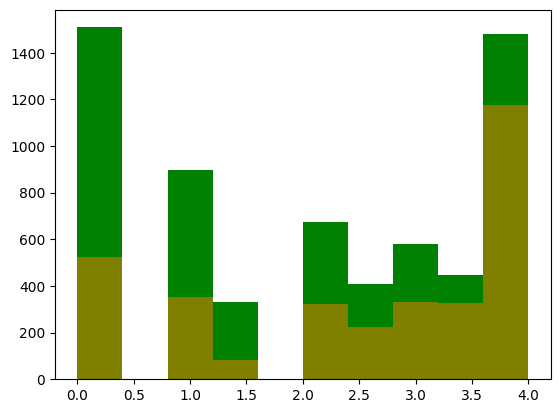

In [73]:
series1 = df_old_rating["chicago_energy_rating"]
series2 = df_new_rating["chicago_energy_rating"]
plt.hist(series1, color = 'green')
plt.hist(series2, color = 'olive')
plt.show()

In [74]:
df_property.nlargest(5, 'total_ghg_emissions_metric_tons_co2e')

,primary_property_type,data_year,id,chicago_energy_rating,gross_floor_area_buildings_sq_ft,year_built,of_buildings,water_use_kgal,energy_star_score,electricity_use_kbtu,...,district_chilled_water_use_kbtu,all_other_fuel_use_kbtu,site_eui_kbtu_sq_ft,source_eui_kbtu_sq_ft,weather_normalized_site_eui_kbtu_sq_ft,weather_normalized_source_eui_kbtu_sq_ft,total_ghg_emissions_metric_tons_co2e,ghg_intensity_kg_co2e_sq_ft,latitude,longitude
5,Convention Center,2017.000000,101551.000000,1.666667,9.245333e+06,1971.000000,8.857143,107949.800000,NaN,4.942120e+08,...,NaN,NaN,94.642857,203.157143,95.714286,201.766667,109206.842857,11.804286,41.852840,-87.634931
7,Data Center,2019.428571,151011.428571,2.000000,4.892620e+05,1914.857143,1.000000,20362.650000,30.857143,3.554284e+08,...,3.697069e+08,NaN,773.842857,2000.966667,785.650000,2162.366667,70408.200000,114.966667,41.869786,-87.630683
39,Prison/Incarceration,2016.846154,154523.307692,2.000000,2.648947e+06,1925.076923,31.153846,129399.166667,NaN,1.041047e+08,...,NaN,NaN,121.169231,201.800000,120.950000,204.800000,32417.684615,11.297692,41.858561,-87.702032
47,Stadium (Open),2015.000000,103669.000000,NaN,1.548634e+06,1924.000000,1.000000,NaN,NaN,1.085296e+08,...,NaN,NaN,81.000000,231.500000,82.700000,235.700000,22703.000000,14.700000,41.863884,-87.614512
12,Hospital (General Medical & Surgical),2017.000000,157508.152542,2.616438,8.688271e+05,1965.225989,2.915254,32570.650000,49.011364,7.921462e+07,...,NaN,1938927.56,263.431073,452.688304,233.863924,427.391608,21598.685965,25.535789,41.872580,-87.661721


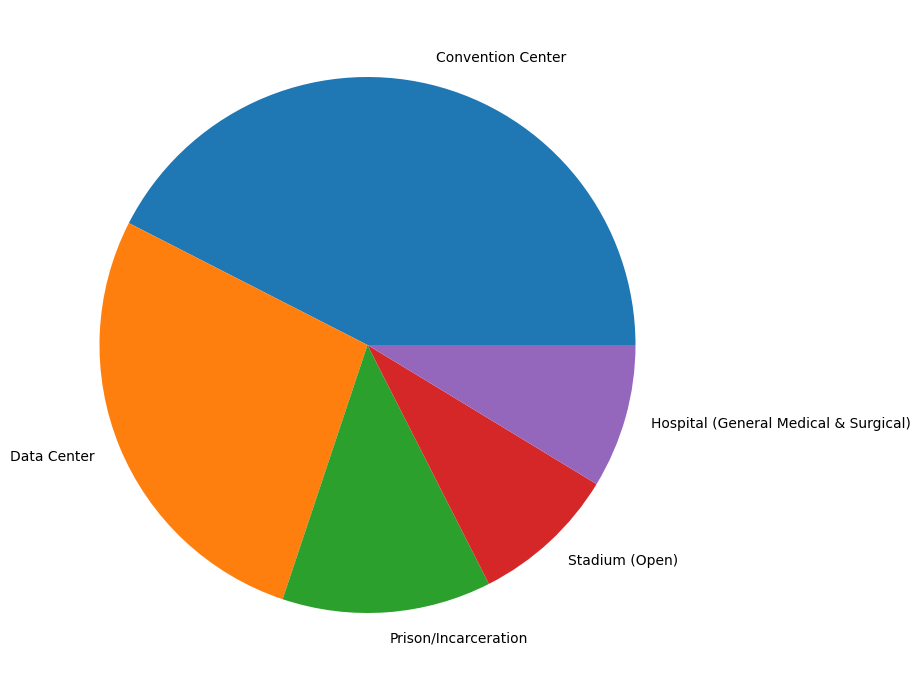

In [75]:
#creating dataset
contributors = ["Convention Center", "Data Center", 'Prison/Incarceration', 'Stadium (Open)', 'Hospital (General Medical & Surgical)']
data = [109206.84, 70408.20, 32417.68, 22703.00, 22325.06]

#creating plot
fig = plt.figure(figsize = (10,7))
plt.pie(data, labels = contributors)

plt.tight_layout()
plt.show()

## **Hypothesis Testing**

**T Test**

In [76]:
# Define the mapping of new categories to existing values

category_mapping = {
    'Multifamily Housing': 'Residential Buildings',
    'Residence Hall/Dormitory': 'Residential Buildings',
    'Senior Care Community': 'Residential Buildings',
    'Senior Living Community': 'Residential Buildings',
    'Residential Care Facility': 'Residential Buildings',
    'Other - Lodging/Residential': 'Residential Buildings',
    'Pre-school/Daycare': 'Residential Buildings',
    'Office': 'Commercial Buildings',
    'Hotel': 'Commercial Buildings',
    'Retail Store': 'Commercial Buildings',
    'Supermarket/Grocery Store': 'Commercial Buildings',
    'Mixed Use Property': 'Commercial Buildings',
    'Strip Mall': 'Commercial Buildings',
    'Enclosed Mall': 'Commercial Buildings',
    'Other - Mall': 'Commercial Buildings',
    'Wholesale Club/Supercenter': 'Commercial Buildings',
    'Financial Office': 'Commercial Buildings',
    'Automobile Dealership': 'Commercial Buildings',
    'Bank Branch': 'Commercial Buildings',
    'Repair Services (Vehicle, Shoe, Locksmith, etc.)': 'Commercial Buildings',
    'Convention Center': 'Commercial Buildings',
    'Data Center': 'Commercial Buildings',
    'Urgent Care/Clinic/Other Outpatient': 'Commercial Buildings',
    'Not Available': 'Commercial Buildings',
    'K-12 School': 'Educational Buildings',
    'College/University': 'Educational Buildings',
    'Adult Education': 'Educational Buildings',
    'Library': 'Educational Buildings',
    'Hospital (General Medical & Surgical)': 'Healthcare Buildings',
    'Medical Office': 'Healthcare Buildings',
    'Other - Specialty Hospital': 'Healthcare Buildings',
    'Ambulatory Surgical Center': 'Healthcare Buildings',
    'Courthouse': 'Government Buildings',
    'Prison/Incarceration': 'Government Buildings',
    'Other - Public Services': 'Government Buildings',
    'Other - Recreation': 'Entertainment Buildings',
    'Performing Arts': 'Entertainment Buildings',
    'Movie Theater': 'Entertainment Buildings',
    'Indoor Arena': 'Entertainment Buildings',
    'Ice/Curling Rink': 'Entertainment Buildings',
    'Laboratory': 'Others',
    'Fitness Center/Health Club/Gym': 'Others',
    'Museum': 'Others',
    'Social/Meeting Hall': 'Others',
    'Other - Entertainment/Public Assembly': 'Others',
    'Other - Services': 'Others',
    'Stadium (Open)': 'Others',
    'Distribution Center': 'Others',
    'Lifestyle Center': 'Others',
    'Worship Facility': 'Others'
}

df['primary_property_type'] = df['primary_property_type'].replace(category_mapping)

In [77]:
counts = df['primary_property_type'].value_counts()
df_drop = df[~df['primary_property_type'].isin(counts[counts < 100].index)]
df_GHG_emission = df_drop.dropna(subset=['ghg_intensity_kg_co2e_sq_ft'])
df_grouped = df_GHG_emission.groupby('primary_property_type')['ghg_intensity_kg_co2e_sq_ft'].agg(['mean', 'sum', 'std', 'count']).reset_index()[['primary_property_type', 'sum', 'mean', 'std', 'count']]
df_grouped = df_grouped.drop(4)
df_grouped = df_grouped.reset_index(drop=True)
df_grouped

,primary_property_type,sum,mean,std,count
0,Commercial Buildings,47988.60,13.905708,15.177380,3451
1,Educational Buildings,25381.35,9.499008,24.379707,2672
2,Entertainment Buildings,2239.00,16.107914,36.353083,139
3,Healthcare Buildings,6328.85,22.284683,11.994794,284
4,Others,7954.52,23.056580,22.755670,345
5,Residential Buildings,51548.40,7.458892,8.018723,6911


**Correlation Test**

In [78]:
counts = df['zip_code'].value_counts()
df_drop = df[~df['zip_code'].isin(counts[counts < 100].index)]
df_GHG_emission = df_drop.dropna(subset=['ghg_intensity_kg_co2e_sq_ft'])
df_grouped = df_GHG_emission.groupby('zip_code')['ghg_intensity_kg_co2e_sq_ft'].agg(['mean', 'sum', 'std', 'count']).reset_index()[['zip_code', 'sum', 'mean', 'std', 'count']]
df_sorted = df_grouped.nlargest(100, "mean")
df_sorted

,zip_code,sum,mean,std,count
31,60637,8890.38,16.282747,14.459247,546
32,60639,1912.10,16.204237,43.514030,118
15,60616,7005.81,14.210568,56.082214,493
26,60628,1704.01,13.007710,26.788766,131
19,60620,1847.45,12.154276,9.111014,152
2,60603,2638.97,11.995318,4.889060,220
28,60631,1589.80,11.864179,5.478169,134
29,60632,1668.38,11.506069,8.627629,145
0,60601,4655.46,11.382543,18.168339,409
17,60618,2446.82,11.380558,9.801187,215


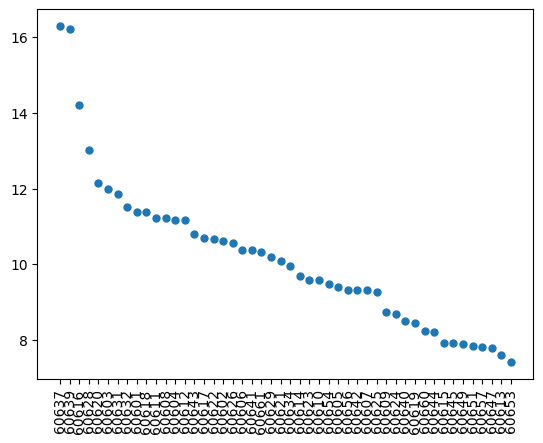

In [79]:
zip_code = "zip_code"
mean = "mean"
plt.scatter(df_sorted[zip_code], df_sorted[mean], s=25)
plt.xticks(rotation=90)
plt.show()

In [80]:
df_sorted[zip_code]  = pd.to_numeric(df_sorted[zip_code]) 
df_sorted[mean] = pd.to_numeric(df_sorted[mean])

A = correlation_coefficient, p_value = stats.pearsonr(df_sorted[zip_code], df_sorted[mean])
A

PearsonRResult(statistic=-0.2546043262155162, pvalue=0.0807483599833235)

In [81]:
# Filter the data by the desired zip codes and select only relevant columns
filtered_data = df[df['zip_code'].isin(['60637', '60639', '60616', '60628', '60620'])][['zip_code', 'primary_property_type']]

# Group the data by zip code and primary property type and count the number of occurrences
analysis_data = filtered_data.groupby(['zip_code', 'primary_property_type']).size().reset_index(name='count')

# Print the resulting data frame
print(analysis_data)

   zip_code    primary_property_type  count
0     60616     Commercial Buildings     35
1     60616    Educational Buildings    106
2     60616     Healthcare Buildings      9
3     60616                    Other      1
4     60616                   Others      6
5     60616    Residential Buildings    378
6     60620     Commercial Buildings     50
7     60620    Educational Buildings     63
8     60620                    Other      3
9     60620                   Others      5
10    60620    Residential Buildings     37
11    60628     Commercial Buildings     18
12    60628    Educational Buildings     76
13    60628                   Others     10
14    60628    Residential Buildings     35
15    60637     Commercial Buildings     51
16    60637    Educational Buildings    141
17    60637  Entertainment Buildings      6
18    60637     Healthcare Buildings     29
19    60637                   Others    161
20    60637    Residential Buildings    175
21    60639     Commercial Build

## **Predictive Analytics**



#### **Multiple** **Linear Regression**

Response Variable: Total GHG Emissions 

Predictor Variables: Elecricity Use, Square Feet of Building

In [82]:
results = smf.ols('total_ghg_emissions_metric_tons_co2e ~ electricity_use_kbtu+gross_floor_area_buildings_sq_ft', data=df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                     
================================================================================================
Dep. Variable:     total_ghg_emissions_metric_tons_co2e   R-squared:                       0.911
Model:                                              OLS   Adj. R-squared:                  0.911
Method:                                   Least Squares   F-statistic:                 7.173e+04
Date:                                  Thu, 27 Apr 2023   Prob (F-statistic):               0.00
Time:                                          13:08:26   Log-Likelihood:            -1.2566e+05
No. Observations:                                 13964   AIC:                         2.513e+05
Df Residuals:                                     13961   BIC:                         2.514e+05
Df Model:                                             2                                         
Covariance Type:                              nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                          142.2051     19.690      7.222      0.000     103.611     180.800
electricity_use_kbtu                 0.0002    9.9e-07    201.031      0.000       0.000       0.000
gross_floor_area_buildings_sq_ft     0.0014   6.59e-05     20.831      0.000       0.001       0.002
==============================================================================
Omnibus:                    29656.604   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        206089736.011
Skew:                          18.440   Prob(JB):                         0.00
Kurtosis:                     597.010   Cond. No.                     3.72e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.72e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### **Classification of Building Size**

In [83]:
df['gross_floor_area_buildings_sq_ft'].describe()

count    1.628400e+04
mean     2.614545e+05
std      4.237493e+05
min      8.000000e+03
25%      7.530000e+04
50%      1.271000e+05
75%      2.770815e+05
max      9.245333e+06
Name: gross_floor_area_buildings_sq_ft, dtype: float64

In [84]:
df['building_size'] = 0
df

,data_year,id,property_name,reporting_status,address,zip_code,chicago_energy_rating,exempt_from_chicago_energy_rating,community_area,primary_property_type,...,weather_normalized_site_eui_kbtu_sq_ft,weather_normalized_source_eui_kbtu_sq_ft,total_ghg_emissions_metric_tons_co2e,ghg_intensity_kg_co2e_sq_ft,latitude,longitude,location,row_id,region,building_size
0,2020,252064,Mansueto Library,Submitted Data,1100 E 57th St,60637,2.0,False,Hyde Park,Educational Buildings,...,246.0,329.9,1160.9,18.1,41.792213,-87.599950,"(41.79221307, -87.59994981)",2020-252064,South,0
1,2020,232458,Harper Square Cooperative,Submitted Data,4800 - 4850 S Lake Park Ave,60615,1.0,False,Kenwood,Residential Buildings,...,100.3,150.7,4871.7,7.8,41.807475,-87.591264,"(41.80747487, -87.59126397)",2020-232458,South,0
2,2020,254616,Former Coyne College,Submitted Data,330 N Green St,60607,2.0,False,Near West Side,Commercial Buildings,...,56.7,151.8,4581.4,8.2,41.873335,-87.651021,"(41.873335, -87.65102071)",2020-254616,"Outside Chicago, In Bedford Park",0
3,2020,103812,400 W Superior St,Submitted Data,400 W Superior St,60654,3.0,False,Near North Side,Commercial Buildings,...,63.0,154.8,1092.1,8.4,41.895752,-87.638901,"(41.89575232, -87.638901)",2020-103812,North,0
4,2020,254073,Blue Moon Lofts,Submitted Data,215 N. Aberdeen St.,60607,4.0,False,Near West Side,Residential Buildings,...,29.6,64.3,295.8,3.6,41.874295,-87.650175,"(41.87429514, -87.65017516)",2020-254073,"Outside Chicago, In Bedford Park",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17632,2019,260132,Q11970,Submitted,2401 W Grace St,60618,3.0,False,North Center,NaN,...,71.7,NaN,NaN,NaN,41.950035,-87.688779,"(41.95003548, -87.68877942)",2019-260132,North,0
17633,2019,260135,309-315 W. 23rd St. Condominium Assocation,Submitted,309 W 23RD ST,60616,4.0,False,Armour Square,Residential Buildings,...,NaN,NaN,NaN,NaN,41.845504,-87.630557,"(41.84550365, -87.63055693)",2019-260135,South,0
17634,2019,260149,Riverside Square and River's Edge - Chicago,Submitted,3145 S Ashland Ave,60608,2.0,False,Mckinley Park,Commercial Buildings,...,253.4,NaN,2448.1,32.9,41.836579,-87.663845,"(41.8365795, -87.66384491)",2019-260149,South,0
17635,2019,260150,Cummings Life Science Center,Submitted,920 E 58th St,60637,2.0,False,Hyde Park,Others,...,413.8,NaN,7815.5,45.3,41.789880,-87.602764,"(41.78987998, -87.60276375)",2019-260150,South,0


In [85]:
size = []

for i in range(len(df)):
  if df['gross_floor_area_buildings_sq_ft'][i] <= 100000:
    size.append('Small')
  elif df['gross_floor_area_buildings_sq_ft'][i] > 100000 and df['gross_floor_area_buildings_sq_ft'][i] <= 1000000:
    size.append('Medium')
  else:
    size.append('Large')

len(size)

df['building_size'] = size
df['building_size'].value_counts()

Medium    9189
Small     6404
Large     2044
Name: building_size, dtype: int64

In [86]:
df = df.dropna(subset=['electricity_use_kbtu'])
df = df.dropna(subset=['natural_gas_use_kbtu'])
df.shape


(13754, 32)

In [93]:
model = ensemble.RandomForestClassifier(min_samples_leaf=50)

features = ['electricity_use_kbtu', 'natural_gas_use_kbtu']

xval = model_selection.KFold(5, shuffle=True)
#scorer = metrics.make_scorer(metrics.accuracy_score)
scorer = metrics.make_scorer(metrics.cohen_kappa_score)

result = model_selection.cross_validate(model, df[features], df['building_size'], cv = xval, scoring=scorer, return_train_score=True)

print('Kappa mean', result['test_score'].mean())
print('Kappa sd', result['test_score'].std())
print('Train Kappa mean', result['train_score'].mean())

Kappa mean 0.8141631010211163
Kappa sd 0.005375683393577622
Train Kappa mean 0.823015145104506


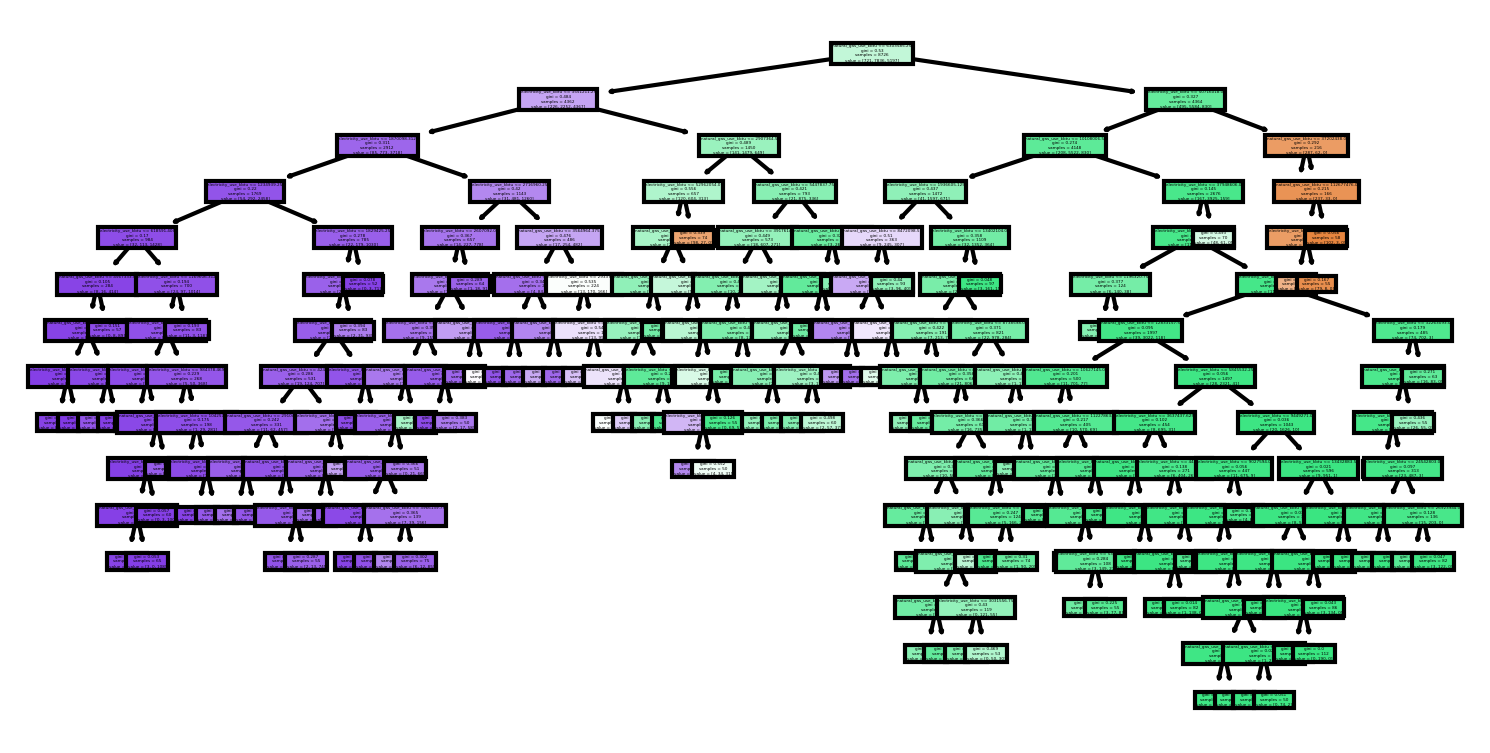

In [88]:
X = df[features]
y = df['building_size']
model.fit(X, y)
plt.figure(dpi=300, figsize=(6,3))
_ = tree.plot_tree(model.estimators_[0], feature_names=X.columns, filled=True)


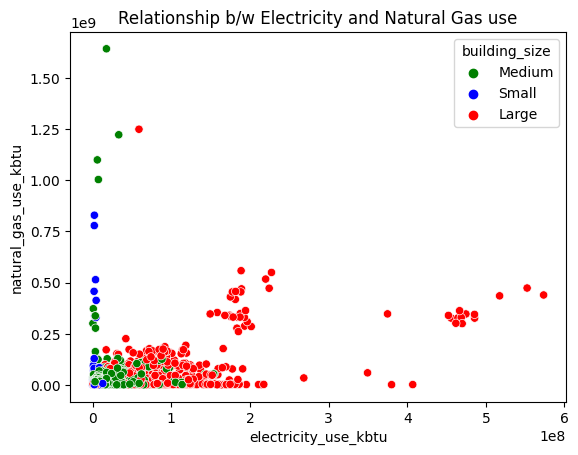

In [94]:
sns.scatterplot(data = df, x = 'electricity_use_kbtu', y = 'natural_gas_use_kbtu', hue = 'building_size', palette = ['green', 'blue', 'red'], markers = ['^', 'o', 's'])
plt.title('Relationship b/w Electricity and Natural Gas use')
plt.show()


In [90]:
model = neighbors.KNeighborsClassifier(n_neighbors=3)

features = ['natural_gas_use_kbtu', 'electricity_use_kbtu']

xval = model_selection.KFold(5, shuffle=True)
scorer = metrics.make_scorer(metrics.cohen_kappa_score)


result = model_selection.cross_validate(model, df[features], df['building_size'], cv = xval, scoring=scorer, return_train_score=True)
print('Kappa mean', result['test_score'].mean())
print('Kappa sd', result['test_score'].std())
print('Train Kappa mean', result['train_score'].mean())

Kappa mean 0.5827208848076069
Kappa sd 0.008416163297772093
Train Kappa mean 0.7528613060214269


In [91]:
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
crs = {'init':'epsg:4326'}

geo_df = gpd.GeoDataFrame(df, crs=crs, geometry=geometry) 
geo_df.head()



NameError: ignored

In [ ]:
street_map = gpd.read_file('/content/chicago_outline.shp')

fig, ax = plt.subplots(figsize=(10,10))
street_map.plot(ax=ax, alpha=0.4, color='grey')
geo_df[geo_df['building_size'] == "Small"].plot(ax=ax, 
                                       markersize=20, 
                                       color='blue', 
                                       marker='o', 
                                       label='Small')
geo_df[geo_df['building_size'] == 'Medium'].plot(ax=ax, 
                                       markersize=40, 
                                       color='green', 
                                       marker='^', 
                                       label='Medium')
geo_df[geo_df['building_size'] == 'Large'].plot(ax=ax, 
                                       markersize=60, 
                                       color='red', 
                                       marker='s', 
                                       label='Large')
plt.legend(prop={'size':15})
